+ 김형신 교수님의 엠비언트 인공지능 참고

## [1] 데이터 가져오기

In [1]:
import tensorflow as tf

In [32]:
fashion_mnist = tf.keras.datasets.fashion_mnist

#Load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#Split train set into train/valid set
from sklearn import model_selection

x_train, x_valid , y_train, y_valid = model_selection.train_test_split(x_train, y_train, test_size = 0.2)

print('데이터의 shape는 다음과 같음 : ',x_train.shape) # (n_sample, data dim1, data dim2)
print('label 데이터의 형식 예 :', y_train.shape, y_train[1]) # 라벨이 정수로 인코딩 되어 있다.

데이터의 shape는 다음과 같음 :  (48000, 28, 28)
label 데이터의 형식 예 : (48000,) 5


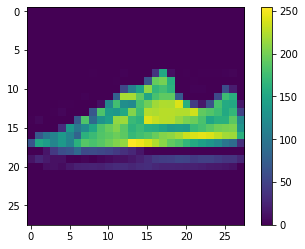

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

## [2] Sequential 모델 구성하기

### (1) 모델 생성

- 28x28 image를 Input으로 받아서 1차원으로 쭉 편 다음,<br> 
- 128개 Node를 가지는 Hidden layer를 연결하고 Relu activation을 한 번 거친 후에, <br>
- 20%를 랜덤으로 누락시키는 Drop Out를 수행한 뒤 <br>
- 10개의 Node를 갖는 Output으로 연결하고 Softmax를 수행한다.<br>

위와 같은 작업을 수행하기 위해 `tf.keras.layers`를 활용 가능하다. 그중에서도 MLP 구성을 위해서는 아래의 Layer들을 활용할 수 있다.
- `Flatten(input_shape=(x,y,z))`: (x,y,z) 형태의 Input을 받아서 1차원 배열로 바꾸어주는 Layer이다.
- `Dense(N, activation=activation)`: 이전 레이어를 Input으로 하고 N만큼을 Output Node로 갖는 Neural Network를 구성한다. activation을 넣어주면 계산된 값에 Activation을 적용한다.(예: ReLU, Softmax 등)
- `Dropout(p)`: 이전 레이어의 Node의 값을 p만큼의 비율로 0으로 만들어 준다.

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),  # (28x28) shape로 변형시킴
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax'),
])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### (2) 모델 컴파일
다음으로 Loss, Optimizer, Metrics등을 정의하여 모델을 컴파일해준다.<br>
- 10개 중 하나로 Classification하는 문제이다.
+ 라벨이 정수로 인코딩 되어있으므로 , `SparseCategoricalCrossentropy`를 Loss로 사용해준다.
+ 라벨이 ont-hot 이라면 `CategoricalCrossentropy`
    + Loss는 `tf.keras.losses` 라이브러리를 사용할 수 있다.
- Optimizer는 가장 널리 쓰이는 방법론 중 하나인 Adam을 사용하자.
    + Optimizer는 `tf.keras.optimizers` 라이브러리를 사용할 수 있다.

In [35]:
# CategoricalCrossentropy : input이 one-hot 인 경우 이용
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()  # label이 int 형태인 경우 이용
optim_fn = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer=optim_fn,
              loss=loss_fn,
              metrics=['accuracy'])

# 이렇게도 가능
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### (3) 콜백
+ **학습률 조정, 중간 가중치 저장, 학습 경과 확인**

callback함수를 통해서 학습을 진행하면서 도중에 Tensorboard로 학습 경과를 확인하고, 중간 가중치를 checkpoint에 저장을 하거나, 학습률을 조정해본다. <br>

**활용 예**

Keras에서 에폭 시작이나 배치 종료, 에폭 종료 시 동작을 구현하는데 유용하게 사용할 수 있다. 예를 들면 아래와 같다.

- 정기적으로 또는 특정 정확도 임계 값을 초과할 때 모델 체크 포인트 생성
- 훈련이 진행됨에 따라 learning rate 조정(Fine tuning 목적)
- 훈련이 정체되는 것처럼 보일 때 훈련을 멈추기
- Tensorboard에서 시각화용으로 활용하기 위한 학습 진행 경과를 저장한다.
- Loss, Metric 등의 로그를 저장한다.
- Custom message를 출력한다.

**사용법**

callback을 사용하기 위해서는 리스트 형태로 callback 함수들을 저장한 뒤, fit()으로 전달해주면 된다. `tf.keras.callbacks.Callback` 라이브러리에 있는 built-in callback 함수들을 잘 활용한다.

- ModelCheckpoint : 주기적으로 모델을 저장한다.
- LearningRateScheduler: Epoch에 따라서 Learning rate를 조정한다.
- EarlyStopping : validation metrics가 향상되지 않을 때 학습을 멈춘다.
- TensorBoard : 시각화하기위해서 모델 log들을 주기적으로 작성해서 텐서보드로 보여준다.
- CSVLogger : loss, metrics data의 stream들을 CSV 파일로 넘긴다.

In [44]:
import tensorflow as tf
import os

#checkpoint가 저장될 경로를 지정해준다.
checkpoint_dir = './training_checkpoints_tfAPI'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

#학습률을 점점 줄이기 위한 함수
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >=3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5
    
#Custom Callback : Learning rate를 각 epoch 마다 print하는 callback함수 설정
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None): #on_train_end(begin)
        print("\n Epoch {}'s Learning rate is {}".format(epoch + 1, model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir = './logs'),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3), #loss를 관찰하다 training을 중간에 그만두게 할 수 있다.
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only = True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

### (3) 모델 훈련
+ model.fit

In [45]:
x_train, x_valid, x_test = x_train / 255.0, x_valid / 255.0, x_test / 255.0
hist = model.fit(x_train, y_train, epochs=3, validation_data=(x_valid, y_valid), callbacks=callbacks)

Epoch 1/3
1480/1500 [============================>.] - ETA: 0s - loss: 2.3506 - accuracy: 0.1076
 Epoch 1's Learning rate is 0.0010000000474974513
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3501 - accuracy: 0.1076 - val_loss: 2.2865 - val_accuracy: 0.1058 - lr: 0.0010
Epoch 2/3
1493/1500 [============================>.] - ETA: 0s - loss: 2.2972 - accuracy: 0.1168
 Epoch 2's Learning rate is 0.0010000000474974513
1500/1500 [==============================] - 6s 4ms/step - loss: 2.2972 - accuracy: 0.1167 - val_loss: 2.2848 - val_accuracy: 0.1010 - lr: 0.0010
Epoch 3/3
1500/1500 [==============================] - ETA: 0s - loss: 2.2915 - accuracy: 0.1222
 Epoch 3's Learning rate is 0.0010000000474974513
1500/1500 [==============================] - 7s 5ms/step - loss: 2.2915 - accuracy: 0.1222 - val_loss: 2.2822 - val_accuracy: 0.1129 - lr: 0.0010


### (4) 훈련 결과 확인

In [46]:
# 콜백 check point 확인
os.listdir(checkpoint_dir)

['ckpt_3.index',
 'ckpt_2.index',
 'checkpoint',
 'ckpt_1.data-00000-of-00001',
 'ckpt_1.index',
 'ckpt_2.data-00000-of-00001',
 'ckpt_3.data-00000-of-00001']

In [37]:
hist.history

{'loss': [1.8915480375289917, 1.2277549505233765, 0.9996028542518616],
 'accuracy': [0.3192916810512543, 0.5568749904632568, 0.6397083401679993],
 'val_loss': [1.3310166597366333, 0.9774665236473083, 0.8112167716026306],
 'val_accuracy': [0.6449166536331177, 0.6882500052452087, 0.7337499856948853]}

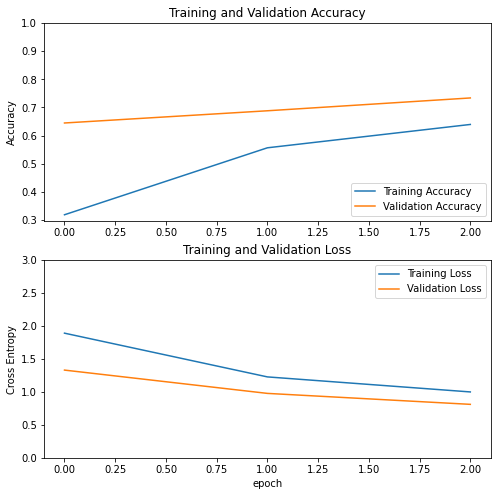

In [38]:
import matplotlib.pyplot as plt
# Get Training accuray & Validation accuracy from history
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Get Training loss & Validation loss from history
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Let's visualize accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Let's visualize loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### (5) 예측 with plt 이미지
+ `model.evaluate` 함수를 통해 Test set에 대해서도 Accuracy가 잘 나오는지 확인해 보자.

In [39]:
model.evaluate(x_test, y_test, verbose=2)

313/313 - 0s - loss: 0.8225 - accuracy: 0.7315 - 466ms/epoch - 1ms/step


[0.8224904537200928, 0.7315000295639038]

In [40]:
predictions = model.predict(x_test)

313/313 [==============================] - 0s 1ms/step


+ 이미지 데이터의 경우, 아래처럼 시각화 가능

In [41]:
import numpy as np
#Plot image with label
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
#Plot 
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='gray')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    _ = plt.xticks(range(10), class_names, rotation=45)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

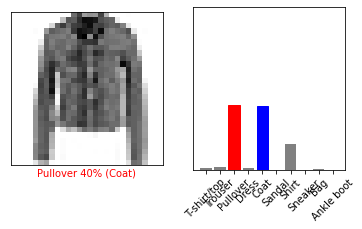

In [42]:
i = 10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions, y_test)
plt.show()

## [3] 모델 저장 및 로드

위에서 설명한 Checkpoint의 경우 모델의 변수정보만 저장된다. 이는 학습 중간중간에 훈련 진행상황을 저장하기에는 적합하지만 모델을 사용하고 싶어하는 다른 사람에게 전달한다면, 그 사람이 변수 정보만 가지고 모델을 다시 구성하기는 쉽지 않은 일이다. 이러한 상황에 대한 해결방안으로 Weight 뿐만 아니라 모델의 전체 정보를 저장하는 방법이 있다.<br>

해당 방법으로 저장할 경우, 
+ 모델의 아키텍처 및 구성
+ 훈련 중에 저장된 모델의 weight
+ 모델의 컴파일 정보
+ 옵티마이저와 그 상태

를 저장한다. 그렇기 때문에 모델을 별도로 Build, compile 하지 않고도 바로 활용가능하다. <br>
<br>
Keras를 이용할 경우 TensorFlow SavedModel 형식 또는 이전에 사용하던 Keras H5 형식으로 저장하는 방법이 있다.

### (1) Tensorflow SavedModel 형식으로 모델을 저장 & 로드하는 방법

#### (a) 저장

In [47]:
#Tensorflow SavedModel 형식으로 모델을 저장하는 방법 -> 2가지 API 존재

path = 'saved_model/'

model.save(path) #1번째 API

tf.keras.models.save_model(model, path) #2번째 API 

In [48]:
os.listdir('saved_model')
#saved_model.pb에는 모델 아키텍처 및 훈련 구성(옵티마이저, loss & matric)이 저장된다.
#가중치의 경우 variables 폴더에 저장된다.
#Assets 폴더에는 Graph 생성에 필요한 정보들이 저장되어 있다.

['variables', 'saved_model.pb', 'keras_metadata.pb', 'assets']

#### (b) 로드

In [49]:
#Saved model을 로드하고 Evaluate
loaded_model = tf.keras.models.load_model(path)
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)

print('loss : {}, accuracy : {}'.format(eval_loss, eval_acc))

313/313 [==============================] - 1s 2ms/step - loss: 2.2822 - accuracy: 0.1132
loss : 2.282170534133911, accuracy : 0.11320000141859055


### (2) Keras H5 형태

In [ ]:
#이전 Keras H5 형태로 저장하는 방법 (옛날 방식)
model.save("my_model.h5")
#단일 HDF5 파일로 저장된다. 이 경우, savedmodel과 비교했을 때, 외부 loss metric은 저장되지 않는다.
#훈련을 재개하고 싶을 때 모델을 로드한 후, 외부 loss metric을 별도로 추가해야 한다.

loaded_model = tf.keras.models.load_model("my_model.h5")
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)

print('loss : {}, accuracy : {}'.format(eval_loss, eval_acc))

## [4] 정규화

In [50]:
#L1 regularization : LASSO
#L2 regularization : Ridge
#Dropout
#Elastic Regularization
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers
    
from tensorflow.keras.regularizers import l2

inputs = tf.keras.Input(shape=(784,))
dense = tf.keras.layers.Dense(64, activation="relu")
x = dense(inputs)

#Regularizer를 적용하고 싶다면 아래와 같이 Layer 생성시 regularizer를 넣어주자.
#Dense layer의 경우 kernel_regularizer, bias_regularizer, activity_regularizer 등을 사용가능하다.
#상세 내용은 Documentation을 참고하라. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
layer = tf.keras.layers.Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))
x = layer(x)

# Dropout layer를 추가하여 Overfitting을 방지할 수도 있다.
dropout = tf.keras.layers.Dropout(0.3)
x = dropout(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

In [53]:
# 모델 컴파일
model = tf.keras.Model(inputs = inputs, outputs=outputs, name="mnist_model")
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
